In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Union
import seaborn as sns
sns.set(rc={"figure.figsize":(10,3)})

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [4]:
with open(".awpy/maps/map-data.json", "r") as f:
    all_map_data = json.load(f)


# analysis over single round

In [5]:
selected_map = 'de_mirage'

In [6]:
map_data = all_map_data[selected_map]
selected_matches = matches_df[matches_df.map_name == selected_map]
display(selected_matches.head())
selected_match = selected_matches.iloc[0]
selected_round = 5
sel_idx = (selected_match.match_id,selected_round)

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


In [7]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num"])
idx_f_df = flashes_df.set_index(["match_id","round_num"])
idx_sm_df = smokes_df.set_index(["match_id","round_num"])
idx_d_df = damages_df.set_index(["match_id","round_num"])

idx_d_df.loc[:,"total_damage"] = idx_d_df["hp_damage"] + idx_d_df["armor_damage"]
idx_d_df.loc[:,"total_damage_taken"] = idx_d_df["hp_damage_taken"] + idx_d_df["armor_damage_taken"]
idx_d_df.attacker_steam_id = idx_d_df.attacker_steam_id.astype("Int64")
idx_d_df.victim_steam_id = idx_d_df.victim_steam_id.astype("Int64")

idx_k_df = kills_df.set_index(["match_id","round_num"])
idx_r_df = rounds_df.set_index(["match_id","round_num"])
idx_r_df["n_ticks"] = idx_r_df["end_tick"]
idx_r_df["bomb_plant_tick"] = idx_r_df["bomb_plant_tick"]

idx_fr_df = frames_df.set_index(["match_id","round_num"])

idx_g_df = grenades_df.set_index(["match_id","round_num"])
idx_g_df["grenade_side"] = idx_g_df.thrower_side
idx_g_df = idx_g_df[idx_g_df.destroy_tick > idx_g_df.throw_tick]

idx_wf_df = weapon_fires_df.set_index(["match_id","round_num"])

In [8]:
all_idx_df = [idx_pf_df, idx_f_df, idx_sm_df, idx_d_df, idx_k_df, idx_fr_df, idx_g_df, idx_wf_df]

for idx in idx_r_df.index:
    first_tick = idx_r_df.loc[idx,"start_tick"]
    for df in all_idx_df:
        tick_cols = [col for col in df.columns if "tick" in col]
        if tick_cols and idx in df.index:
            df.loc[idx,tick_cols] = df.loc[idx,tick_cols]-first_tick

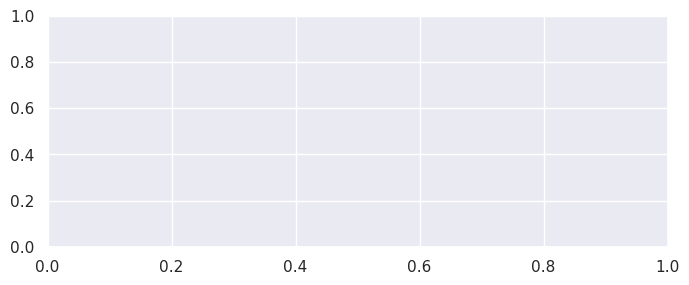

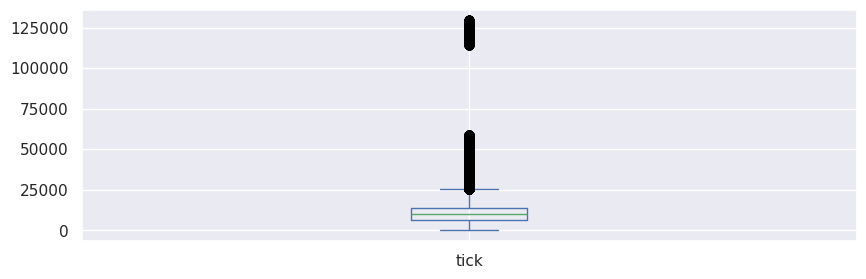

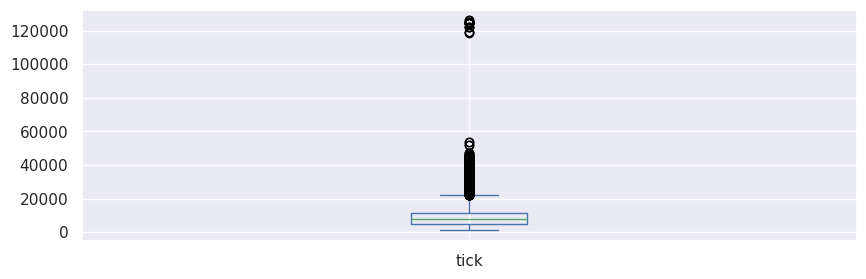

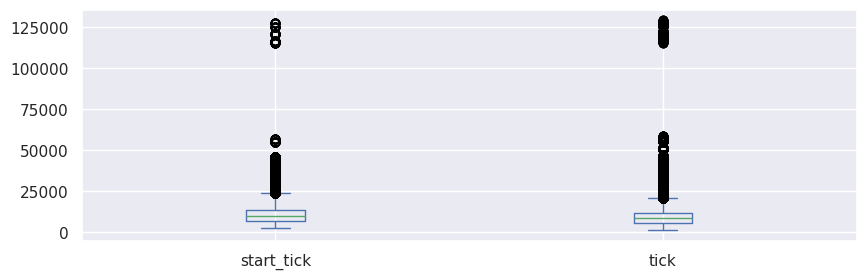

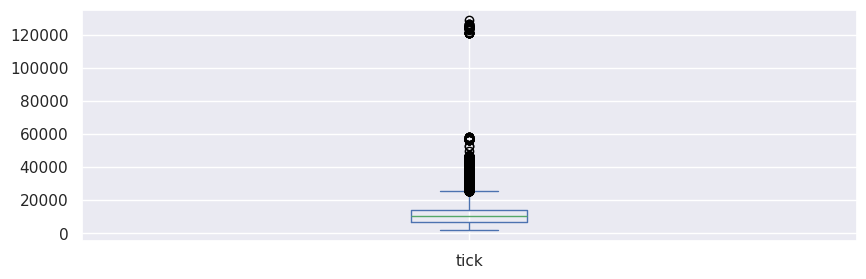

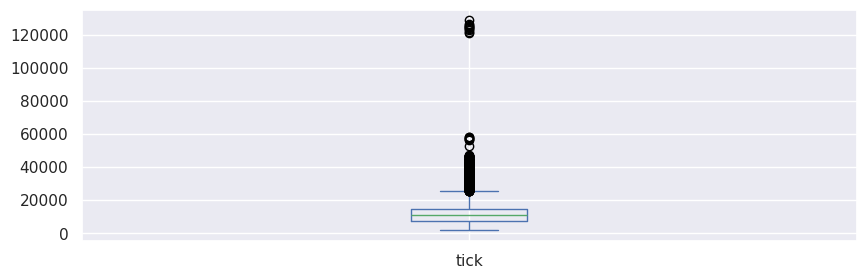

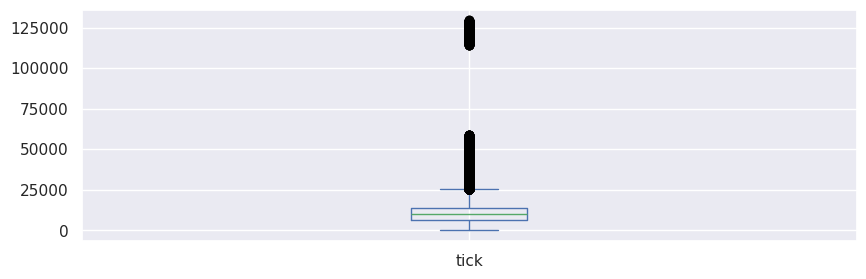

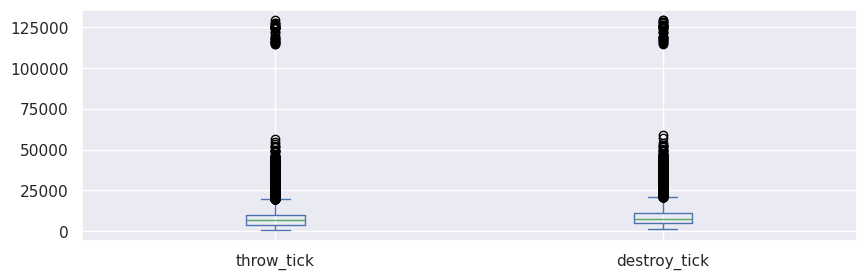

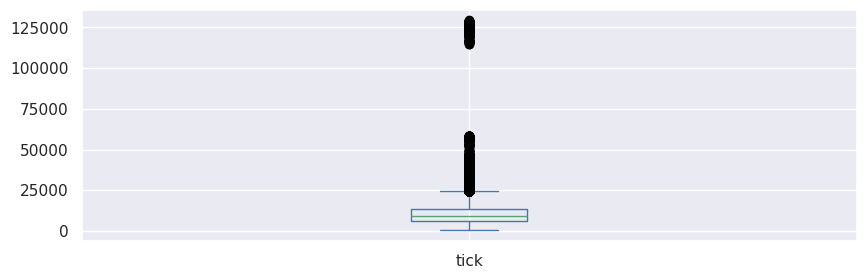

In [9]:
fig,ax = plt.subplots(figsize=(8,3))
for df in all_idx_df:
    tick_cols = [col for col in df.columns if "tick" in col]
    if tick_cols:
        df.loc[:,tick_cols].plot.box(title="")
        plt.show()

In [10]:
[col for col in idx_r_df.columns if "tick" in col]

['start_tick',
 'freeze_time_end_tick',
 'end_tick',
 'end_official_tick',
 'bomb_plant_tick',
 'n_ticks']

In [11]:
# Loop through each unique match+round combination
for idx in idx_wf_df.index.unique():
    round_wf = idx_wf_df.loc[idx].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    round_d = idx_d_df.loc[idx].copy()
        
        
    round_wf['combo_key'] = round_wf['tick'].astype(str) + '_' + round_wf['player_steam_id'].astype('float64')\
    .astype(str)
    round_d['combo_key'] = round_d['tick'].astype(str) + '_' + round_d['attacker_steam_id'].astype("float64")\
    .astype(str)
    
    round_wf['shot_connected'] = round_wf['combo_key'].isin(round_d['combo_key'].values)

    round_wf.drop('combo_key', axis=1, inplace=True)
    
    if len(round_wf) > 0:
        if isinstance(idx_wf_df.loc[idx], pd.Series):
            idx_wf_df.loc[idx, 'shot_connected'] = round_wf['shot_connected'].iloc[0]
        else:
            idx_wf_df.loc[idx, 'shot_connected'] = round_wf['shot_connected'].values

## location based analysis over single round

### transform functions
so data fit the plotting format

In [12]:
def transform_coord(map_data,player_loc,x_col="x",y_col="y"):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result[x_col] = (result[x_col] - pos_x) / scale
    result[y_col] = image_dim - (pos_y - result[y_col]) / scale

    return result

#### transform coordinates
to transform for plotting in the map

In [13]:
def transform_coords(map_data,player_loc,status):
    tf = player_loc.copy()
    for st in status:
        tf = transform_coord(map_data,tf,x_col=f"{st}_x",y_col=f"{st}_y")
    return tf

In [14]:
def transform_flash(flashes):
    flashers_cols = [col for col in flashes.columns
                     if not (col.startswith('player_') or col == 'flash_duration')]
    flashers = flashes.loc[:, flashers_cols]
    
    flasheds_cols = [col for col in flashes.columns if not col.startswith('attacker_')]
    flasheds = flashes.loc[:, flasheds_cols]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:, "status"] = "flasher"
        flasheds.loc[:, "status"] = "flashed"
    
    flashers.columns = [col.replace("attacker_", "") if col != "attacker_side" else col 
                        for col in flashers.columns]
    flasheds.columns = [col.replace("player_", "") if col != "player_side" else col 
                        for col in flasheds.columns]
    
    result = pd.concat([flashers.drop_duplicates(), flasheds.drop_duplicates()])
    result["side"] = result["attacker_side"].fillna(result["player_side"])
    result.sort_values(["tick"],inplace=True)
    
    subset_col = [col for col in result.columns if col not in ["status","flash_duration"]]
    print(subset_col)
    dup_idx = result.duplicated(subset=subset_col)
    keep_idx = result.duplicated(subset=subset_col,keep="last")
    result.loc[dup_idx,"status"] = "both"
    return result.loc[~keep_idx,:]

#### transform action
again, to fit the plotting function and cleaner look, (dim reduce)

In [15]:
def transform_actions(actions: pd.DataFrame, 
                      status: List[str], 
                      status_extra_cols: Dict[str, List[str]] = {},
                      status_code: Dict[str, str] = {},
                      common_extra_cols: List[str] = [],
                      rename_col:Dict[str,str] = {},
                      check_dup_without_cols: List[str] = [],
                      keep: str = "first",
                      assign_dup: dict = {},
                     drop_na_cols: List[str] = []) -> pd.DataFrame:
    """Transforms action data.

    This function processes action data, potentially enriching it with status
    information, handling duplicates, and adding common extra columns.

    Args:
        actions (pd.DataFrame): The action data to transform.
        status (List[str]): Status information to merge with the action data.
        status_extra_cols (Dict[str, List[str]], optional): Extra columns from the
            status data to include in the transformed output. Defaults to {}.
        status_code (Dict[str, str], optional): A mapping to use when
            processing status codes. Defaults to {}.
        common_extra_cols (List[str], optional): A list of extra columns to add
            to the output. Defaults to [].
        check_dup_cols (List[str], optional): Columns to check for duplicates.
            Defaults to [].
        keep (str, optional): How to handle duplicates. See the pandas
            'DataFrame.drop_duplicates' keep parameter. Defaults to "first".
        assign_dup (dict, optional): How to assign values to duplicates.
            Defaults to {}.

    Returns:
        pd.DataFrame: The transformed action data.
    """
    keep_opts = {"first" : "last","last":"first"}
    result = pd.DataFrame()
    for st in status:
        st_cols = []
        extra_cols = status_extra_cols.get(st,[])
        for col in actions.columns:
            if col.startswith(st):
                st_cols.append(col)

            if col in extra_cols:
                st_cols.append(col)

            if col in common_extra_cols:
                st_cols.append(col)
        st_df = actions.loc[:,st_cols]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
            code = status_code.get(st,None)
            st_df.loc[:, "status"] = code if code is not None else st

        new_cols = []
        for col in st_df.columns:
            if col == f"{st}_side":
                new_cols.append(col)
                continue
            replaced_col = col.replace(f"{st}_","")
            new_cols.append(rename_col.get(replaced_col,replaced_col))
        st_df.columns = new_cols
        # st_df.columns = [col.replace(f"{st}_","") if col != f"{st}_side" else col
        #                 for col in st_df.columns]

        result = pd.concat([result.drop_duplicates(),
                            st_df.drop_duplicates()
                           ])

    side = result[f"{status[0]}_side"]
    for st in status[1:]:
        side = side.fillna(result[f"{st}_side"])
    result["side"] = side
    if check_dup_without_cols is not None and check_dup_without_cols:
        check_dup_cols = [col for col in result.columns if col not in check_dup_without_cols]
        dup_idx = result.duplicated(subset=check_dup_cols,keep=keep_opts[keep])
        keep_idx = result.duplicated(subset=check_dup_cols,keep=keep)
        for key,value in assign_dup.items():
            result.loc[dup_idx,key] = value

        result = result.loc[~keep_idx,:]
        
    return result

### plotting functions

In [16]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [17]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     default_color="viridis",  # Default colormap when color_by is None
                     alpha=0.5,
                     marker_by=None,
                     marker_dict=None,
                     default_marker="o",       # Default marker when marker_by is None
                     fig=None, ax=None):

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    selected_col = ["x", "y", gradient_by]
    if color_by is not None:
        selected_col.append(color_by)
    if marker_by is not None:
        selected_col.append(marker_by)

    transformed = player_loc.reset_index()[selected_col]

    # Normalize gradient
    vmin = transformed[gradient_by].min()
    vmax = transformed[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    if color_by is not None:
        transformed[color_by] = transformed[color_by].str.lower()

    side = ['left', 'right']
    n_colorbar = count_colorbar(fig)

    previous_cmap = plt.get_cmap(default_color)  # Initial cmap

    for idx, row in transformed.iterrows():
        # Determine colormap
        if color_by is not None and pd.notna(row[color_by]):
            color_key = row[color_by]
            if color_key in color_dict:
                cmap = plt.get_cmap(color_dict[color_key])
                previous_cmap = cmap
            else:
                cmap = previous_cmap
        else:
            cmap = previous_cmap

        # Normalize and get color
        color_value = norm(row[gradient_by])
        color = cmap(color_value)

        # Determine marker
        if marker_by is None:
            marker_char = default_marker
        else:
            marker_key = row[marker_by]
            marker_char = marker_dict.get(marker_key, default_marker)

        ax.text(row["x"], row["y"], marker_char,
                fontsize=size, color=color, ha='center', va='center',
                alpha=alpha)

    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")

    # Add colorbars if color_by is provided
    if color_by is not None:
        for idx, (color_cat, cmap_name) in enumerate(list(color_dict.items())[:2-n_colorbar]):
            positions = transformed[transformed[color_by] == color_cat]
            dummy_scatter = ax.scatter(positions['x'], positions['y'],
                                       c=positions[gradient_by],
                                       cmap=cmap_name, s=0, alpha=.5,
                                       norm=norm)
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                                fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)

    return fig, ax


In [19]:
def plot_line(actions,status1,status2,
              gradient_by,
              color_by=None,color_dict={},default_color="Greys",
              linewidth=1,alpha=1,
             fig=None,ax=None):
    if fig is None and ax is None:
        fig,ax = plt.subplots(figsize=(10,8))
        
    vmin = actions[gradient_by].min()
    vmax = actions[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    for idx,row in actions.iterrows():
        cmap = plt.get_cmap(
            color_dict.get(row[color_by],default_color) if color_by is not None else default_color
        )
        
        color_value = norm(row[gradient_by])
        color = cmap(color_value)
        
        ax.plot([row[f"{status1}_x"],row[f"{status2}_x"]],
                [row[f"{status1}_y"],row[f"{status2}_y"]],
               alpha=alpha,linewidth=linewidth,
               color=color)

    return fig,ax

### test plotting functions with players' location and flashes' location

51799 70859


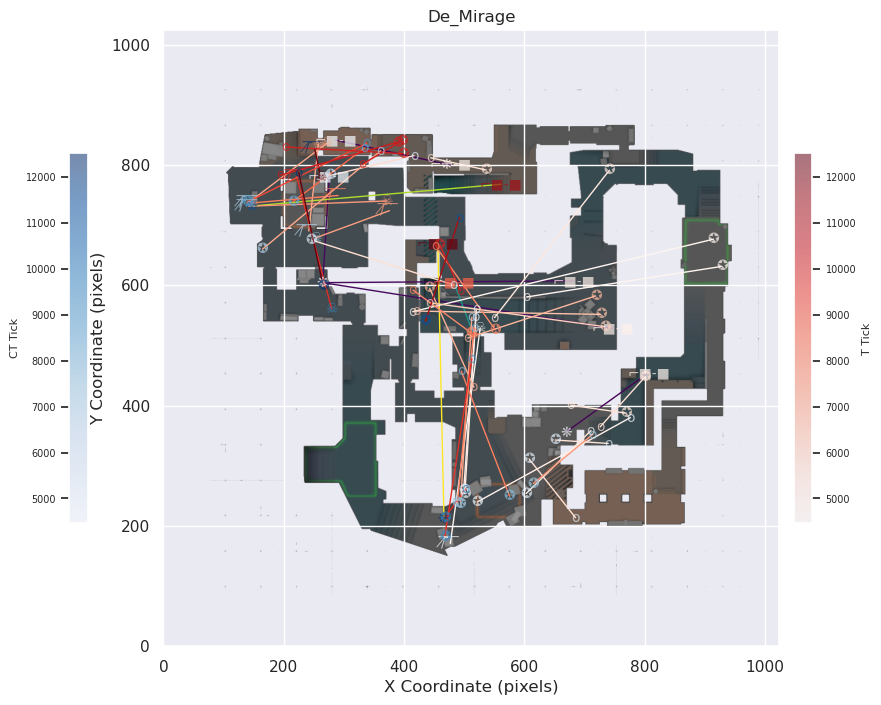

In [20]:
min_tick,max_tick = idx_r_df.loc[sel_idx][["start_tick","end_tick"]].values
print(min_tick,max_tick)

tf_f_co = transform_coords(map_data,
                          idx_f_df.loc[sel_idx],
                         ["attacker","player"])
transformed_flash = transform_actions(tf_f_co,
                 ["attacker","player"],
                 {"player" : ["flash_duration",]},
                 {"attacker" : "flasher","player" : "flashee"},
                  check_dup_without_cols=["status","flash_duration","attacker_side","player_side"],
                  assign_dup={"status":"both"},
                 common_extra_cols = ["tick"],
                 )

tf_k_co = transform_coords(map_data,idx_k_df.loc[sel_idx],["attacker","victim"])
transformed_kills = transform_actions(tf_k_co,
                 ["attacker","victim"],
                  check_dup_without_cols=["attacker_side","victim_side"],
                  assign_dup={"status":"suicide"},
                 common_extra_cols = ["tick"],
                )
                                      
tf_g_co = transform_coords(map_data,idx_g_df.loc[sel_idx],["thrower","grenade"])
transformed_grenades = transform_actions(tf_g_co,
                 ["thrower","grenade"],
                 common_extra_cols = ["throw_tick"],
                                     )
side_color = {
    "ct" : "Blues",
    "t" : "Reds"
}

flash_marker = {
    "flasher" : "$\u274B$",
    "flashee" : "⌐■-■",
    "both" : "⌐$\u274B$-■"
}

kill_marker = {
    "attacker" : "/̸̅̅ ̆̅ ̅̅ ̅̅",
    "victim" : "$\u2620$",
    "suicide" : "$\u2622$"
}

grenade_marker = {
    "thrower" : "✪",
    "victim" : "☄",
}
img_fig, img_ax = plot_map(selected_map, (10, 8))

flash_fig, flash_ax = plot_loc_unicode(transformed_flash, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=flash_marker,
                                      alpha=0.7,
                                      fig=img_fig, 
                                      ax=img_ax)

cf_fig,cf_ax = plot_line(tf_f_co,"attacker","player","tick",default_color="viridis",fig=flash_fig,ax=flash_ax)      

kill_fig, kill_ax = plot_loc_unicode(transformed_kills, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=kill_marker,
                                      alpha=0.7,
                                      fig=cf_fig, 
                                      ax=cf_ax)

ck_fig,ck_ax = plot_line(tf_k_co,"attacker","victim","tick",default_color="Reds",fig=kill_fig,ax=kill_ax)      
grenade_fig, grenade_ax = plot_loc_unicode(transformed_grenades, 
                                      gradient_by="throw_tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="status",
                                      marker_dict=grenade_marker,
                                      alpha=0.7,
                                      fig=ck_fig, 
                                      ax=ck_ax)

cg_fig,cg_ax = plot_line(tf_g_co,"thrower","grenade","throw_tick",default_color="Reds",fig=grenade_fig,ax=grenade_ax)      
plt.show()

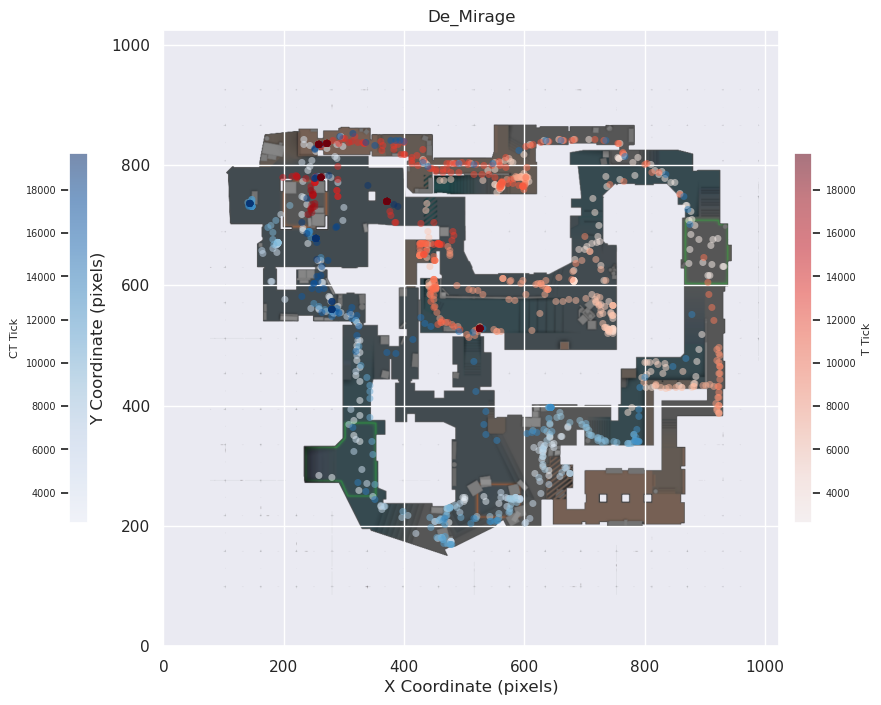

In [21]:
transformed_loc = transform_coord(map_data,
                                  idx_pf_df.loc[sel_idx].iloc[::2])
img_loc_fig,img_loc_ax =  plot_map(selected_map, (10, 8))

loc_fig, loc_ax = plot_loc_unicode(transformed_loc, 
                                  gradient_by="tick",
                                  size=5,
                                  color_by="side",
                                  color_dict=side_color,
                                  default_marker="$\u2B24$",
                                  fig=img_loc_fig, 
                                  ax=img_loc_ax)

### interactive plotting

In [22]:
from ipywidgets import interact, IntSlider, Layout, HBox, VBox, FloatSlider, Checkbox
import ipywidgets as widgets
from IPython.display import display

# This function definition assumes plot_map, plot_loc_unicode, plot_line, and transform_coords 
# functions are already defined elsewhere in your code

def plot_actions_by_max_tick(max_tick=100, 
                            show_flash=True, 
                            show_kills=True, 
                            show_grenades=True,
                            flash_alpha=0.7,
                            kill_alpha=0.7,
                            grenade_alpha=0.7,
                            flash_size=10,
                            kill_size=10,
                            grenade_size=10,
                            show_lines=True):
    """
    Interactive plot of game actions filtered by maximum tick
    Everything from tick 0 up to max_tick will be shown
    """
    # Set min_tick to the minimum value or 0
    min_tick = global_min_tick
    
    # Clear previous plots
    plt.figure(figsize=(12, 10))
    
    # Start with map
    img_fig, img_ax = plot_map(selected_map, (12, 10))
    current_fig, current_ax = img_fig, img_ax
    
    # Filter actions by tick range
    flash_mask = (transformed_flash['tick'] >= min_tick) & (transformed_flash['tick'] <= max_tick)
    kill_mask = (transformed_kills['tick'] >= min_tick) & (transformed_kills['tick'] <= max_tick)
    grenade_mask = (transformed_grenades['throw_tick'] >= min_tick) & (transformed_grenades['throw_tick'] <= max_tick)
    
    filtered_flash = transformed_flash[flash_mask] if isinstance(transformed_flash, pd.DataFrame) else transformed_flash
    filtered_kills = transformed_kills[kill_mask] if isinstance(transformed_kills, pd.DataFrame) else transformed_kills
    filtered_grenades = transformed_grenades[grenade_mask] if isinstance(transformed_grenades, pd.DataFrame) else transformed_grenades

    flash_count = filtered_flash.attacker_side.notnull().sum()
    kill_count = filtered_kills.attacker_side.notnull().sum()
    grenade_count = filtered_grenades.thrower_side.notnull().sum()
    
    # Plot flashes if requested
    if show_flash and len(filtered_flash) > 0:
        flash_fig, flash_ax = plot_loc_unicode(filtered_flash, 
                                          gradient_by="tick", 
                                          size=flash_size,
                                          color_by="side",
                                          color_dict=side_color,
                                          marker_by="status",
                                          marker_dict=flash_marker,
                                          alpha=flash_alpha,
                                          fig=current_fig, 
                                          ax=current_ax)
        current_fig, current_ax = flash_fig, flash_ax
        
        # Plot flash lines if requested
        if show_lines:
            flash_co_mask = (tf_f_co["tick"] >= min_tick) & (tf_f_co["tick"] <= max_tick)
            filtered_f_co = tf_f_co[flash_co_mask] if isinstance(tf_f_co, pd.DataFrame) else tf_f_co
            if len(filtered_f_co) > 0:
                cf_fig, cf_ax = plot_line(filtered_f_co, "attacker", "player", "tick", 
                                         default_color="viridis", fig=current_fig, ax=current_ax)
                current_fig, current_ax = cf_fig, cf_ax
    
    # Plot kills if requested
    if show_kills and len(filtered_kills) > 0:
        kill_fig, kill_ax = plot_loc_unicode(filtered_kills, 
                                          gradient_by="tick", 
                                          size=kill_size,
                                          color_by="side",
                                          color_dict=side_color,
                                          marker_by="status",
                                          marker_dict=kill_marker,
                                          alpha=kill_alpha,
                                          fig=current_fig, 
                                          ax=current_ax)
        current_fig, current_ax = kill_fig, kill_ax
        
        # Plot kill lines if requested
        if show_lines:
            kill_co_mask = (tf_k_co["tick"] >= min_tick) & (tf_k_co["tick"] <= max_tick)
            filtered_k_co = tf_k_co[kill_co_mask] if isinstance(tf_k_co, pd.DataFrame) else tf_k_co
            if len(filtered_k_co) > 0:
                ck_fig, ck_ax = plot_line(filtered_k_co, "attacker", "victim", "tick", 
                                         default_color="Reds", fig=current_fig, ax=current_ax)
                current_fig, current_ax = ck_fig, ck_ax
    
    # Plot grenades if requested
    if show_grenades and len(filtered_grenades) > 0:
        grenade_fig, grenade_ax = plot_loc_unicode(filtered_grenades, 
                                              gradient_by="throw_tick", 
                                              size=grenade_size,
                                              color_by="side",
                                              color_dict=side_color,
                                              marker_by="status",
                                              marker_dict=grenade_marker,
                                              alpha=grenade_alpha,
                                              fig=current_fig, 
                                              ax=current_ax)
        current_fig, current_ax = grenade_fig, grenade_ax
        
        # Plot grenade lines if requested
        if show_lines:
            grenade_co_mask = (tf_g_co["throw_tick"] >= min_tick) & (tf_g_co["throw_tick"] <= max_tick)
            filtered_g_co = tf_g_co[grenade_co_mask] if isinstance(tf_g_co, pd.DataFrame) else tf_g_co
            if len(filtered_g_co) > 0:
                cg_fig, cg_ax = plot_line(filtered_g_co, "thrower", "grenade", "throw_tick", 
                                         default_color="Greens", fig=current_fig, ax=current_ax)
    
    # Add title with tick range info
    plt.title(f'Game Actions (Tick range: {min_tick} - {max_tick})', fontsize=14)

    # Show number of events in the filtered range
    
    # Add a text box with event counts
    info_text = f"Events in range: {flash_count} flashes, {kill_count} kills, {grenade_count} grenades"
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


global_min_tick = idx_pf_df.loc[sel_idx].tick.min()
global_max_tick = idx_pf_df.loc[sel_idx].tick.max()


# Create the interactive widgets
max_tick_slider = IntSlider(
    value=global_max_tick,
    min=global_min_tick,
    max=global_max_tick,
    step=1,
    description='Max Tick:',
    style={'description_width': 'initial'},
    layout=Layout(width='600px')
)

flash_checkbox = Checkbox(
    value=True,
    description='Show Flashes',
    style={'description_width': 'initial'}
)

kill_checkbox = Checkbox(
    value=True,
    description='Show Kills',
    style={'description_width': 'initial'}
)

grenade_checkbox = Checkbox(
    value=True,
    description='Show Grenades',
    style={'description_width': 'initial'}
)

lines_checkbox = Checkbox(
    value=True,
    description='Show Lines',
    style={'description_width': 'initial'}
)

flash_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Flash Opacity:',
    style={'description_width': 'initial'}
)

kill_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Kill Opacity:',
    style={'description_width': 'initial'}
)

grenade_alpha_slider = FloatSlider(
    value=0.7,
    min=0.1,
    max=1.0,
    step=0.1,
    description='Grenade Opacity:',
    style={'description_width': 'initial'}
)

flash_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Flash Size:',
    style={'description_width': 'initial'}
)

kill_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Kill Size:',
    style={'description_width': 'initial'}
)

grenade_size_slider = IntSlider(
    value=10,
    min=5,
    max=30,
    step=1,
    description='Grenade Size:',
    style={'description_width': 'initial'}
)

# Organize the widgets into a more user-friendly layout
tick_controls = VBox([max_tick_slider])
event_controls = HBox([flash_checkbox, kill_checkbox, grenade_checkbox, lines_checkbox])

flash_controls = VBox([flash_alpha_slider, flash_size_slider])
kill_controls = VBox([kill_alpha_slider, kill_size_slider])
grenade_controls = VBox([grenade_alpha_slider, grenade_size_slider])

appearance_controls = HBox([flash_controls, kill_controls, grenade_controls])

all_controls = VBox([tick_controls, event_controls, appearance_controls])

# Create the interactive output
interactive_output = widgets.interactive_output(
    plot_actions_by_max_tick,
    {
        'max_tick': max_tick_slider,
        'show_flash': flash_checkbox,
        'show_kills': kill_checkbox,
        'show_grenades': grenade_checkbox,
        'flash_alpha': flash_alpha_slider,
        'kill_alpha': kill_alpha_slider,
        'grenade_alpha': grenade_alpha_slider,
        'flash_size': flash_size_slider,
        'kill_size': kill_size_slider,
        'grenade_size': grenade_size_slider,
        'show_lines': lines_checkbox
    }
)

display(all_controls)
display(interactive_output)



Output()

# player stats

In [23]:
# import sys
# print(idx_pf_df.index)
# for idx in idx_pf_df.index.unique():
#     sel_pf = idx_pf_df.loc[idx]
#     print(f"working on {idx}",end="\r")
#     p_count = len(sel_pf.steam_id.unique())
#     if p_count != 10:
#         print(f"at {idx} player missing, only {p_count} player")
#     sys.stdout.flush()

In [24]:
def get_players_stat(idx):
    
    all_players = idx_pf_df.loc[idx][["steam_id","name","team",]]\
    .drop_duplicates().set_index(["name"])
    max_round = idx_pf_df.loc[idx].index.max()
    
    sel_k = idx_k_df.loc[idx]
    sel_d = idx_d_df.loc[idx]
    
    
    for name in all_players.index:
        sel_player_kill_mask = sel_k.attacker_name == name
        sel_player_death_mask = sel_k.victim_name == name
        sel_player_assist_mask = sel_k.assister_name == name
        sel_player_flash_assist_mask = sel_k.flash_thrower_name == name
        sel_player_traded_mask = sel_k.player_traded_name == name
    
        
        k = sel_player_kill_mask.groupby("round_num").any()
        a = sel_player_assist_mask.groupby("round_num").any() | sel_player_flash_assist_mask.groupby("round_num").any()
        s = ~(sel_player_death_mask.groupby("round_num").any())
        t = sel_player_traded_mask.groupby("round_num").any()
    
        sel_player_kill = sel_k[sel_player_kill_mask]
        sel_player_death = sel_k[sel_player_death_mask]
        sel_player_assist = sel_k[sel_player_assist_mask]
        sel_player_flash_assist = sel_k[sel_player_flash_assist_mask]
        
        # display(sel_player_death)
        
        all_players.loc[name,"kills"] = len(sel_player_kill)
        all_players.loc[name,"deaths"] = len(sel_player_death)
        all_players.loc[name,"assist"] = len(sel_player_assist)
        all_players.loc[name,"flash_assist"] = len(sel_player_flash_assist)
        all_players.loc[name,"first_kill"] = sel_player_kill.is_first_kill.sum()
        all_players.loc[name,"first_death"] = sel_player_death.is_first_kill.sum()
        all_players.loc[name,"kast"] = (k|a|s|t).sum() / max_round
        
    
        sel_player_damage = sel_d[sel_d.attacker_name == name]
        sel_player_dmg_round = sel_player_damage.groupby("round_num").agg(
            rtd=("total_damage","sum")
        )
        all_players.loc[name,"ADR"] =sel_player_dmg_round.rtd.sum() / max_round
    return all_players
get_players_stat(selected_match.match_id)
    

,steam_id,team,kills,deaths,assist,flash_assist,first_kill,first_death,kast,ADR
name,,,,,,,,,,
misutaaa,76561198081528911,Vitality,17.0,18.0,0.0,1.0,2.0,5.0,0.521739,95.565217
Magisk,76561197983956651,Vitality,14.0,18.0,2.0,4.0,1.0,2.0,0.652174,84.608696
dupreeh,76561198004854956,Vitality,12.0,18.0,6.0,0.0,0.0,3.0,0.608696,91.956522
ZywOo,76561198113666193,Vitality,14.0,17.0,5.0,4.0,3.0,1.0,0.782609,131.173913
apEX,76561197989744167,Vitality,17.0,18.0,6.0,0.0,2.0,4.0,0.652174,140.956522
TeSeS,76561197996678278,Heroic,10.0,15.0,5.0,2.0,1.0,3.0,0.739130,79.217391
cadiaN,76561198004115516,Heroic,19.0,15.0,3.0,4.0,4.0,1.0,0.782609,102.869565
sjuush,76561198160709585,Heroic,12.0,14.0,8.0,1.0,3.0,0.0,0.826087,95.652174
stavn,76561198022365638,Heroic,26.0,16.0,3.0,1.0,4.0,1.0,0.695652,181.521739


# statistical analysis over rounds

## extracting data for each round

In [25]:
warnings.filterwarnings("ignore")

sel_r_df = idx_r_df[["n_ticks","bomb_plant_tick","winning_side","round_end_reason",
                     "ct_round_spend_money","ct_buy_type","ct_round_start_eq_val","ct_freeze_time_end_eq_val",
                     "t_round_spend_money","t_buy_type","t_round_start_eq_val","t_freeze_time_end_eq_val"]]

def check_nan(val,default = 0,show=False):
    result =  val if not pd.isna(val) else default
    # if show:
    #     print(result)
    return val if not pd.isna(val) else default
for idx,row in list(sel_r_df.iterrows()):
    if idx in idx_f_df.index:
        sel_f_df = idx_f_df.loc[idx]
        ct_flasher_idx = sel_f_df["attacker_side"] == "CT"
        t_flasher_idx = sel_f_df["attacker_side"] == "T"
        ct_flashed_idx = sel_f_df["player_side"] == "CT"
        t_flashed_idx = sel_f_df["player_side"] == "T"
        
        sel_r_df.loc[idx,"ct_flash_opp"] = check_nan(ct_flashed_idx.sum(),0,True)
        sel_r_df.loc[idx,"t_flash_opp"] = check_nan(t_flasher_idx.sum(),0,True)
        sel_r_df.loc[idx,"ct_flashed"] = check_nan(ct_flashed_idx.sum(),0,True)
        sel_r_df.loc[idx,"t_flashed"] = check_nan(t_flashed_idx.sum(),0,True)
        
        sel_r_df.loc[idx,"ct_avg_flash_duration"] = check_nan(sel_f_df.loc[ct_flashed_idx,"flash_duration"].mean(),0,True)
        sel_r_df.loc[idx,"t_avg_flash_duration"] = check_nan(sel_f_df.loc[t_flashed_idx,"flash_duration"].mean(),0,True)
    else:
        flash_columns = ["ct_flash_opp", "t_flash_opp", "ct_flashed", "t_flashed", "ct_avg_flash_duration", "t_avg_flash_duration"]
        for col in flash_columns:
            sel_r_df.loc[idx, col] = 0

    if idx in idx_k_df.index:
        sel_k_df = idx_k_df.loc[idx]
        ct_atk_idx = sel_k_df["attacker_side"]=="CT"
        t_atk_idx = sel_k_df["attacker_side"]=="T"
        ct_vic_idx = sel_k_df["victim_side"]=="CT"
        t_vic_idx = sel_k_df["victim_side"]=="T"

        ct_n_k = sel_k_df.loc[ct_atk_idx].attacker_steam_id.nunique()
        t_n_k = sel_k_df.loc[t_atk_idx].attacker_steam_id.nunique()

        ct_n_a = sel_k_df.loc[ct_atk_idx].assister_steam_id.nunique(dropna=True)
        t_n_a = sel_k_df.loc[t_atk_idx].assister_steam_id.nunique(dropna=True)

        ct_n_s = 5-ct_vic_idx.sum()
        t_n_s = 5-t_vic_idx.sum()
        
        ct_n_t = sel_k_df.loc[ct_atk_idx].player_traded_steam_id.nunique(dropna=True)
        t_n_t = sel_k_df.loc[t_atk_idx].player_traded_steam_id.nunique(dropna=True)

        ct_kast = max(ct_n_k,ct_n_a,ct_n_s,ct_n_t)
        t_kast = max(t_n_k,t_n_a,t_n_s,t_n_t)
        
        sel_r_df.loc[idx,"ct_kills"] = ct_atk_idx.sum()
        sel_r_df.loc[idx,"t_kills"] = t_atk_idx.sum()
        sel_r_df.loc[idx,"ct_deaths"] = ct_vic_idx.sum()
        sel_r_df.loc[idx,"t_deaths"] = t_vic_idx.sum()

        # print(sel_k_df.loc[ct_atk_idx,"is_first_kill"].any(),sel_k_df.loc[t_atk_idx,"is_first_kill"].any())

        sel_r_df.loc[idx,"ct_first_kill"] = sel_k_df.loc[ct_atk_idx]["is_first_kill"].any().astype(int)
        sel_r_df.loc[idx,"t_first_kill"] = sel_k_df.loc[t_atk_idx]["is_first_kill"].any().astype(int)

        sel_r_df.loc[idx,"ct_hs_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["is_headshot"].mean(),0)
        sel_r_df.loc[idx,"t_hs_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["is_headshot"].mean(),0)
        
        sel_r_df.loc[idx,"ct_trade_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["is_trade"].mean(),0)
        sel_r_df.loc[idx,"t_trade_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["is_trade"].mean(),0)
        
        sel_r_df.loc[idx,"ct_flash_kill_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["victim_blinded"].mean(),0)
        sel_r_df.loc[idx,"t_flash_kill_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["victim_blinded"].mean(),0)
        
        sel_r_df.loc[idx,"ct_assist_prob"] = check_nan(sel_k_df.loc[ct_atk_idx]["assister_steam_id"].notnull().mean(),0)
        sel_r_df.loc[idx,"t_assist_prob"] = check_nan(sel_k_df.loc[t_atk_idx]["assister_steam_id"].notnull().mean(),0)

        sel_r_df.loc[idx,"ct_kast_prob"] = ct_kast / 5
        sel_r_df.loc[idx,"t_kast_prob"] = t_kast / 5
    if idx in idx_d_df.index:
        sel_d_df = idx_d_df.loc[idx]
        
        ct_atk_idx = sel_d_df["attacker_side"]=="CT"
        t_atk_idx = sel_d_df["attacker_side"]=="T"
        ct_vic_idx = sel_d_df["victim_side"]=="CT"
        t_vic_idx = sel_d_df["victim_side"]=="T"

        sel_r_df.loc[idx,"ct_damage_done"] = sel_d_df.loc[ct_atk_idx,"total_damage"].sum()
        sel_r_df.loc[idx,"t_damage_done"] = sel_d_df.loc[t_atk_idx,"total_damage"].sum()
        
        sel_r_df.loc[idx,"ct_damage_taken"] = sel_d_df.loc[ct_vic_idx,"total_damage_taken"].sum()
        sel_r_df.loc[idx,"t_damage_taken"] = sel_d_df.loc[t_vic_idx,"total_damage_taken"].sum()

    if idx in idx_wf_df.index:
        sel_wf_df = idx_wf_df.loc[idx]
        
        ct_ply_idx = sel_wf_df["player_side"]=="CT"
        t_ply_idx = sel_wf_df["player_side"]=="T"

        sel_r_df.loc[idx,"ct_shot_fires"] = ct_ply_idx.sum()
        sel_r_df.loc[idx,"t_shot_fires"] = t_ply_idx.sum()

        sel_r_df.loc[idx,"ct_shot_connected_prob"] = sel_wf_df.loc[ct_ply_idx]["shot_connected"].mean()
        sel_r_df.loc[idx,"t_shot_connected_prob"] = sel_wf_df.loc[t_ply_idx]["shot_connected"].mean()

sel_r_df["bomb_plant_tick"].fillna(-1,inplace=True)

In [26]:
sel_r_df.isnull().sum()

n_ticks                      0
bomb_plant_tick              0
winning_side                 0
round_end_reason             0
ct_round_spend_money         0
ct_buy_type                  0
ct_round_start_eq_val        0
ct_freeze_time_end_eq_val    0
t_round_spend_money          0
t_buy_type                   0
t_round_start_eq_val         0
t_freeze_time_end_eq_val     0
ct_flash_opp                 0
t_flash_opp                  0
ct_flashed                   0
t_flashed                    0
ct_avg_flash_duration        0
t_avg_flash_duration         0
ct_kills                     0
t_kills                      0
ct_deaths                    0
t_deaths                     0
ct_first_kill                0
t_first_kill                 0
ct_hs_prob                   0
t_hs_prob                    0
ct_trade_prob                0
t_trade_prob                 0
ct_flash_kill_prob           0
t_flash_kill_prob            0
ct_assist_prob               0
t_assist_prob                0
ct_kast_

In [27]:
start_round_cols = ["ct_round_spend_money","ct_buy_type","ct_round_start_eq_val","ct_freeze_time_end_eq_val",
                     "t_round_spend_money","t_buy_type","t_round_start_eq_val","t_freeze_time_end_eq_val"]

## create df w/ lag

In [28]:
lag_r_df = pd.concat([
    sel_r_df,
    pd.DataFrame(np.nan, index=sel_r_df.index, columns=[f"lag_{col}" for col in sel_r_df.columns])
], axis=1)

non_lag_cols = [col for col in sel_r_df.columns]  # Use sel_r_df columns directly to be safe
lag_cols = [f"lag_{col}" for col in non_lag_cols]  # Ensure lag columns match non-lag columns

for match_id, round_num in lag_r_df.index:
    prev_round_idx = (match_id, round_num-1)
    if prev_round_idx in lag_r_df.index:
        # Assign values FROM previous round TO current round's lag columns
        for i, col in enumerate(non_lag_cols):
            lag_r_df.loc[(match_id, round_num), f"lag_{col}"] = lag_r_df.loc[prev_round_idx, col]
lag_r_df.dropna(how="any",inplace=True)
display(lag_r_df)

n_ticks  bomb_plant_tick  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 2            29455          24206.0   
                                     3            51519          46270.0   
                                     4            98753             -1.0   
                                     5           113164             -1.0   
                                     6           130356             -1.0   
...                                                 ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13          183596             -1.0   
                                     14          197648             -1.0   
                                     15          208908             -1.0   
                                     16          254837         250353.0   
                                     17          270761             -1.0   

                                               winning_side round_end_reason  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                    T     TargetBombed   
                                     3                    T     TargetBombed   
                                     4                   CT      TargetSaved   
                                     5                   CT            CTWin   
                                     6                   CT            CTWin   
...                                                     ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT            CTWin   
                                     14                  CT            CTWin   
                                     15                  CT            CTWin   
                                     16                  CT      BombDefused   
                                     17                   T    TerroristsWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
                                     6                         12550   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
                                     6            Full Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                           1000   
                                     3                 

In [29]:
lag_df = lag_r_df[["winning_side"]+start_round_cols\
+[col for col in lag_r_df.columns if col.startswith("lag_")]]
lag_df

winning_side  \
match_id                             round_num                
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                    T   
                                     3                    T   
                                     4                   CT   
                                     5                   CT   
                                     6                   CT   
...                                                     ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT   
                                     14                  CT   
                                     15                  CT   
                                     16                  CT   
                                     17                   T   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
                                     6                         12550   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
                                     6            Full Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                           1000   
                                     3                           4600   
                                     4                           1100   
                                     5                           1000   
                                     6                          18650   
...                                                               ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         12650   
                                     14                         25200   
                                     15                         22150   
                                     16                          1000   
                                     17                          1650   

                                                ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              18350   
                                     6                              305

In [30]:
for col in lag_r_df.select_dtypes(include=["category","object"]).columns:
    print(col,lag_r_df[col].nunique())

winning_side 2
round_end_reason 5
ct_buy_type 4
t_buy_type 4
lag_winning_side 2
lag_round_end_reason 5
lag_ct_buy_type 4
lag_t_buy_type 4


## df w/ cumulative vals

In [31]:
cumulative_cols = ['ct_round_spend_money',  'ct_round_start_eq_val',
       't_round_spend_money', 't_round_start_eq_val',
       'ct_flash_opp', 't_flash_opp', 'ct_flashed', 't_flashed',
       'ct_avg_flash_duration', 't_avg_flash_duration', 'ct_kills', 't_kills',
       'ct_deaths', 't_deaths', 'ct_first_kill', 't_first_kill', 'ct_hs_prob',
       't_hs_prob', 'ct_trade_prob', 't_trade_prob', 'ct_flash_kill_prob',
       't_flash_kill_prob', 'ct_assist_prob', 't_assist_prob', 'ct_kast_prob',
       't_kast_prob', 'ct_damage_done', 't_damage_done', 'ct_damage_taken',
       't_damage_taken', 'ct_shot_fires', 't_shot_fires',
       'ct_shot_connected_prob', 't_shot_connected_prob']

cumu_df = sel_r_df.copy()
for idx in cumu_df.index:
    curr_round = idx[1]
    if curr_round <= 15:
        start_round = 0
    else:
        start_round = 15
    target_cols = [f"cumu_{col}" for col in cumulative_cols]
    cumu_val =  cumu_df.loc[idx[0],cumulative_cols].iloc[start_round:curr_round-1].mean().fillna(0).values
    cumu_df.loc[idx,target_cols] = cumu_val

with pd.option_context('display.max_rows',20,'display.max_columns', None):
    display(cumu_df)
    

n_ticks  bomb_plant_tick  \
match_id                             round_num                             
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            13026           9411.0   
                                     2            29455          24206.0   
                                     3            51519          46270.0   
                                     4            98753             -1.0   
                                     5           113164             -1.0   
...                                                 ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13          183596             -1.0   
                                     14          197648             -1.0   
                                     15          208908             -1.0   
                                     16          254837         250353.0   
                                     17          270761             -1.0   

                                               winning_side round_end_reason  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    T    TerroristsWin   
                                     2                    T     TargetBombed   
                                     3                    T     TargetBombed   
                                     4                   CT      TargetSaved   
                                     5                   CT            CTWin   
...                                                     ...              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT            CTWin   
                                     14                  CT            CTWin   
                                     15                  CT            CTWin   
                                     16                  CT      BombDefused   
                                     17                   T    TerroristsWin   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                           1000   
                                     2                 

In [32]:
cumu_df = cumu_df[["winning_side"]+start_round_cols\
+[col for col in lag_r_df.columns if col.startswith("cumu_")]]
cumu_df

winning_side  \
match_id                             round_num                
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    T   
                                     2                    T   
                                     3                    T   
                                     4                   CT   
                                     5                   CT   
...                                                     ...   
816e1612-9d2e-4893-af23-bda90c479598 13                  CT   
                                     14                  CT   
                                     15                  CT   
                                     16                  CT   
                                     17                   T   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   
...                                                              ...   
816e1612-9d2e-4893-af23-bda90c479598 13                        22350   
                                     14                         9000   
                                     15                        12450   
                                     16                         3350   
                                     17                        19450   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   
...                                                    ...   
816e1612-9d2e-4893-af23-bda90c479598 13           Full Buy   
                                     14           Full Buy   
                                     15           Full Buy   
                                     16           Full Eco   
                                     17           Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                           1000   
                                     2                           1000   
                                     3                           4600   
                                     4                           1100   
                                     5                           1000   
...                                                               ...   
816e1612-9d2e-4893-af23-bda90c479598 13                         12650   
                                     14                         25200   
                                     15                         22150   
                                     16                          1000   
                                     17                          1650   

                                                ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               4300   
                                     2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              183

In [33]:
r_df = sel_r_df[["winning_side"]+start_round_cols]
r_df.head(5)

winning_side  \
match_id                             round_num                
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                    T   
                                     2                    T   
                                     3                    T   
                                     4                   CT   
                                     5                   CT   

                                                ct_round_spend_money  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          3300   
                                     2                         10200   
                                     3                          1300   
                                     4                         26050   
                                     5                         17350   

                                               ct_buy_type  \
match_id                             round_num               
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            Full Eco   
                                     2            Semi Buy   
                                     3            Semi Eco   
                                     4            Full Buy   
                                     5            Semi Buy   

                                                ct_round_start_eq_val  \
match_id                             round_num                          
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                           1000   
                                     2                           1000   
                                     3                           4600   
                                     4                           1100   
                                     5                           1000   

                                                ct_freeze_time_end_eq_val  \
match_id                             round_num                              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                               4300   
                                     2                              10600   
                                     3                               5300   
                                     4                              27450   
                                     5                              18350   

                                                t_round_spend_money  \
match_id                             round_num                        
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                         3550   
                                     2                        17000   
                                     3                        11500   
                                     4                        13750   
                                     5                        15200   

                                               t_buy_type  \
match_id                             round_num              
bfa9bbbe-bd16-4713-bd99-745378db05cb 1           Full Eco   
                                     2           Semi Buy   
                                     3           Full Buy   
                                     4           Full Buy   
                                     5           Full Buy   

                                                t_round_start_eq_val  \
match_id                             round_num                         
bfa9bbbe-bd16-4713-bd99-745378db05cb 1                          1000   
                                     2                          1650   
                                     3                         11550   
                                     4                         15050   
                                     5                         11750   

                                                t_freeze_time_end_eq_val  
match_id                             round_num                            
bfa9bbbe-bd16-4713-bd99-745378db

## feature importance w/ classification

In [34]:
from sklearn.model_selection import train_test_split
# Use the lag_r_df that was created earlier
target_df = r_df
add_feature = ""
add_feature_prefix=add_feature+"_"
target_df_reset = target_df.reset_index()

# Filter to keep only the columns we need
features_to_keep = [col for col in target_df_reset.columns 
                    if col not in ["match_id", "round_num", "round_end_reason"] and
                   not (col.endswith("_kills") or col.endswith("_deaths"))]

# Create the model DataFrame
model_df = target_df_reset[features_to_keep]
# # Convert winning_side to binary (1 for CT win, 0 otherwise)
win = "CT"
model_df["winning_side"] = (model_df["winning_side"] == win).astype(int)


cat_cols = model_df.select_dtypes(include=["object","category"]).columns

# Print to check what we found
# print(f"Categorical columns identified: {cat_cols}")

model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)
# corr = model_df.corr()[["winning_side"]]
# corr = corr[(abs(corr.winning_side) > 0.2) & (abs(corr.winning_side) < 0.8)]
# corr.sort_values("winning_side",ascending=False,inplace=True)
# display(corr)
display(model_df.head(5))

# # B. Select features (X) and target variable (y)


,winning_side,ct_round_spend_money,ct_round_start_eq_val,ct_freeze_time_end_eq_val,t_round_spend_money,t_round_start_eq_val,t_freeze_time_end_eq_val,ct_buy_type_Full Eco,ct_buy_type_Semi Buy,ct_buy_type_Semi Eco,t_buy_type_Full Eco,t_buy_type_Semi Buy,t_buy_type_Semi Eco
0,0,3300,1000,4300,3550,1000,4350,True,False,False,True,False,False
1,0,10200,1000,10600,17000,1650,18000,False,True,False,False,True,False
2,0,1300,4600,5300,11500,11550,22000,False,False,True,False,False,False
3,1,26050,1100,27450,13750,15050,27550,False,False,False,False,False,False
4,1,17350,1000,18350,15200,11750,26650,False,True,False,False,False,False


<Axes: xlabel='winning_side', ylabel='count'>

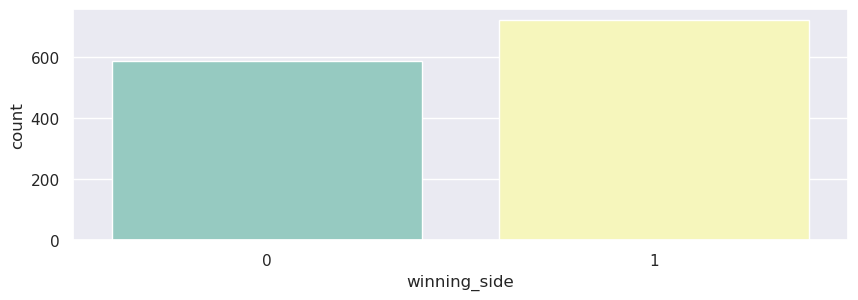

In [35]:
sns.countplot(data=model_df,x="winning_side",palette="Set3")

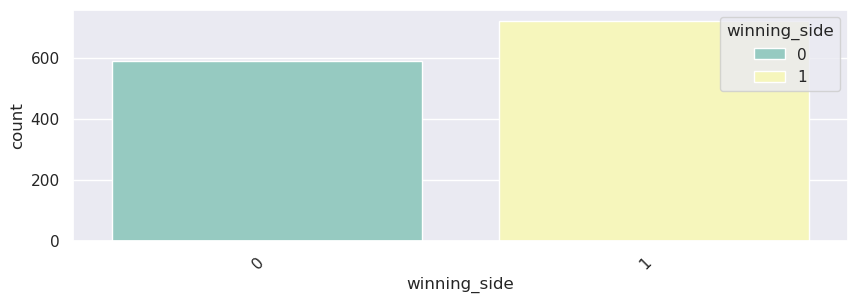

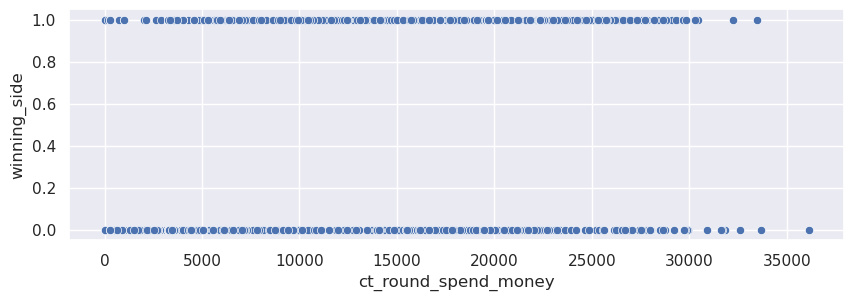

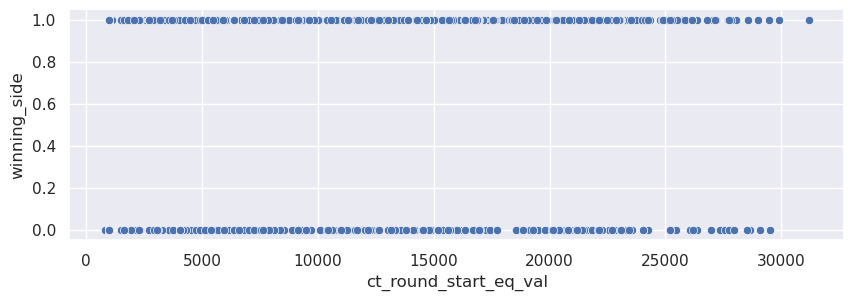

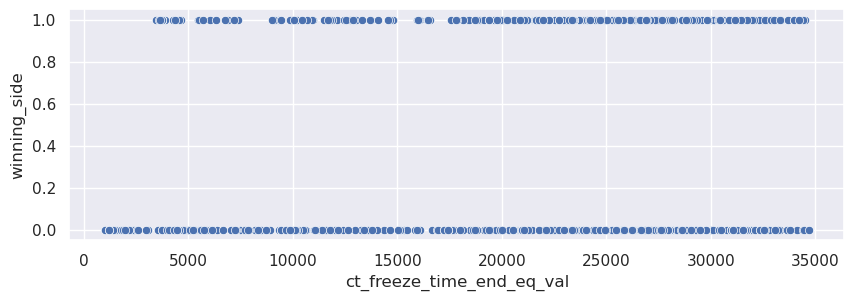

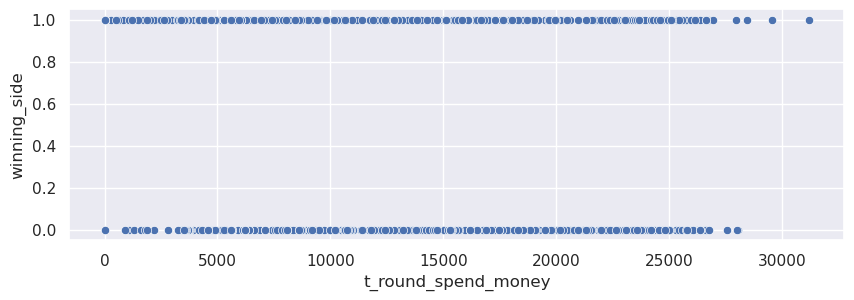

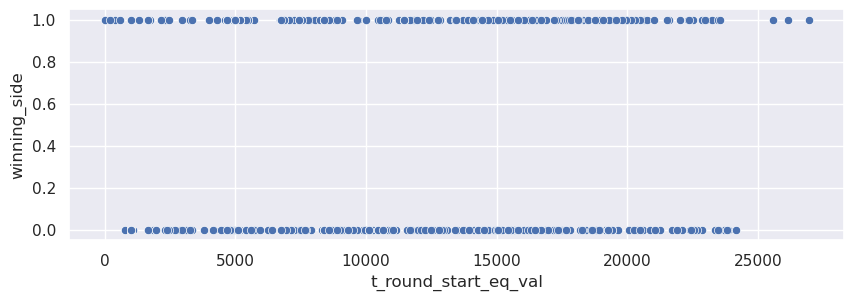

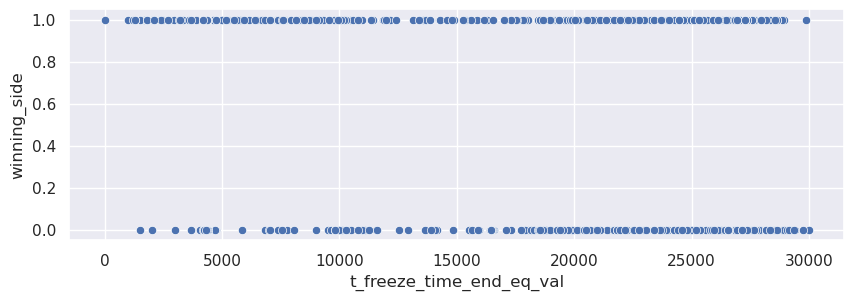

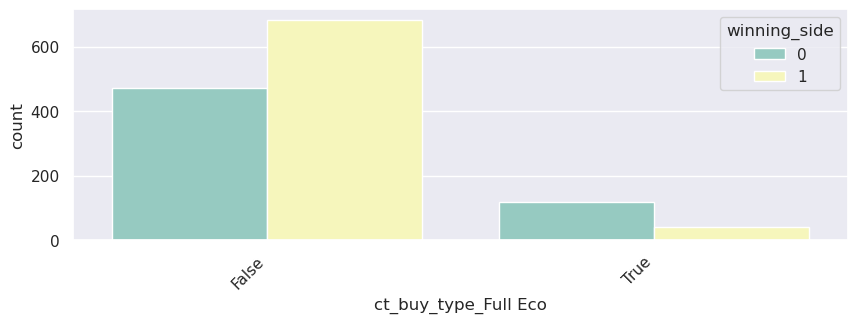

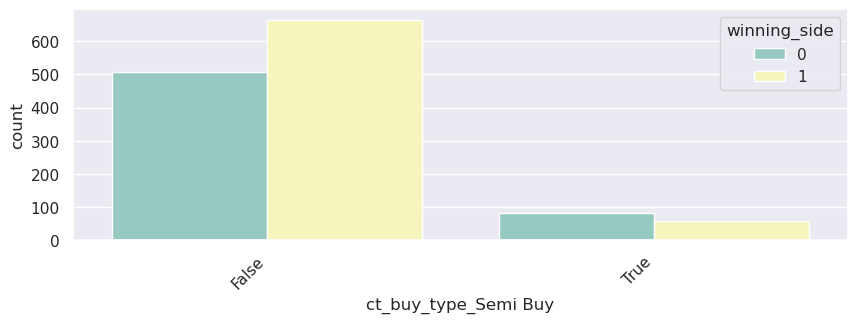

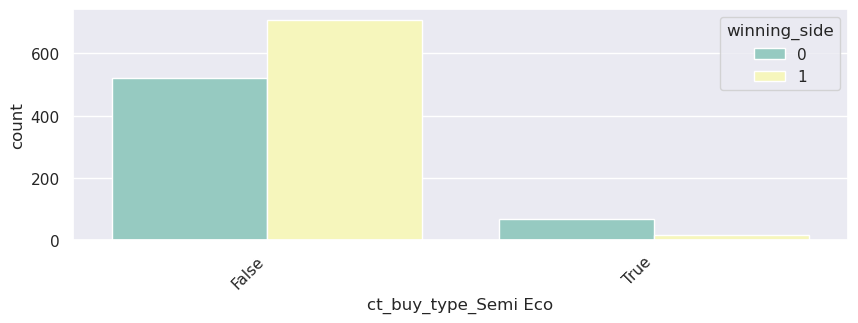

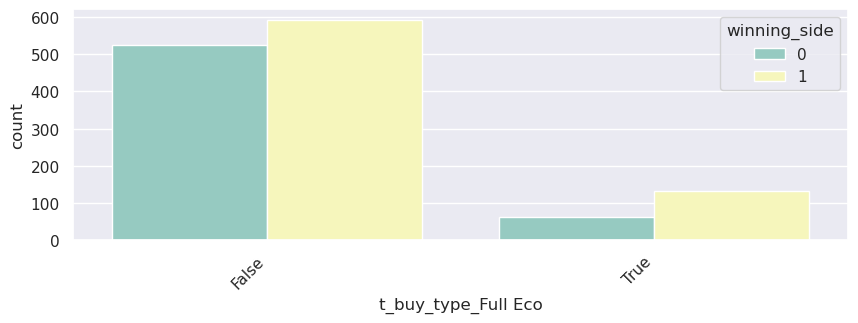

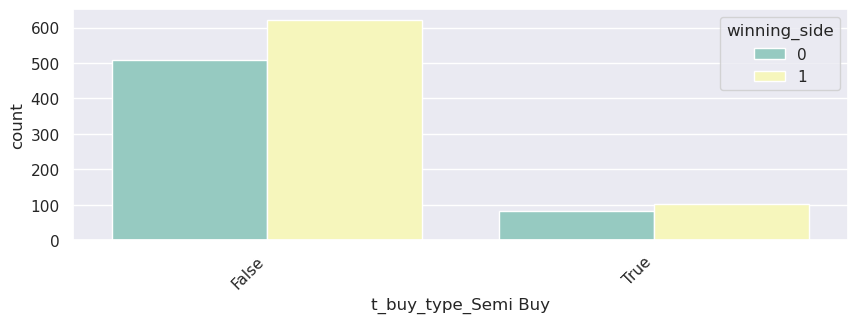

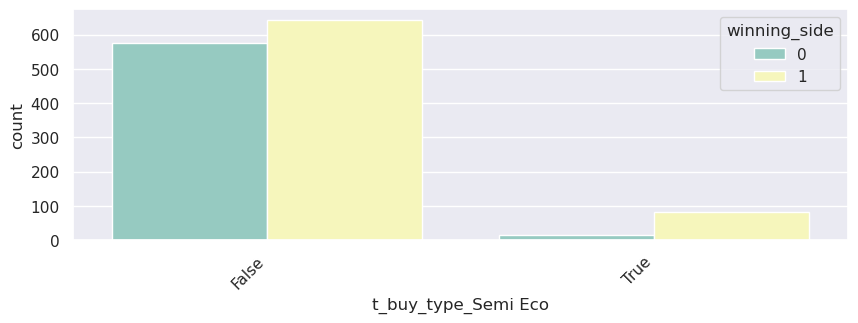

In [36]:
for col in model_df.columns:
    if model_df[col].nunique()<20:
        plt.xticks(rotation=45, ha='right')
        sns.countplot(x=col,data=model_df,hue="winning_side",palette="Set3")
    else:
        sns.scatterplot(data=model_df,x=col,y="winning_side")
    plt.show()

In [37]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy

def calculate_gain_ratio(df, target_column='winning_side'):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    information_gains = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    
    gain_ratios = {}
    feature_names = X.columns
    
    for i, feature_name in enumerate(feature_names):
        # Calculate split information
        feature_values = X[feature_name].value_counts(normalize=True).values
        split_info = entropy(feature_values, base=2)
        
        # Avoid division by zero
        if split_info > 0:
            gain_ratio = information_gains[i] / split_info
        else:
            gain_ratio = 0
            
        yield feature_name,gain_ratio
    

gain_ratios = sorted(filter(lambda p : p[1] > 0, calculate_gain_ratio(model_df)),key = lambda p : p[1],reverse=True)
print("Gain Ratios:")
for feature, ratio in gain_ratios:
    print(f"{feature}: {ratio:.4f}")

Gain Ratios:
ct_buy_type_Semi Eco: 0.0946
ct_buy_type_Full Eco: 0.0676
t_buy_type_Semi Buy: 0.0433
t_buy_type_Semi Eco: 0.0408
t_round_start_eq_val: 0.0116
ct_freeze_time_end_eq_val: 0.0094
t_freeze_time_end_eq_val: 0.0058
ct_round_start_eq_val: 0.0053
ct_round_spend_money: 0.0041
t_buy_type_Full Eco: 0.0029
t_round_spend_money: 0.0019


In [38]:
features = [col for col in model_df.columns if col != 'winning_side']
X = model_df[features]
y = model_df['winning_side']


# # Print info about the data
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features: {len(features)}")
print(f"Number of {add_feature} features: {sum(1 for col in features if col.startswith(add_feature_prefix))}")

# # 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of feature matrix: (1312, 12)
Number of features: 12
Number of  features: 0


### decision tree clf

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Create and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42, criterion="gini")
model.fit(X_train, y_train)

# When evaluating the model performance:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances)

# Analyze additional vs normal feature importance
additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]

print("\nTop 5 Additional Feature Importances:")
print(additional_importances.head(5))
print("\nTop 5 Normal Feature Importances:")
print(normal_importances.head(5))

# Calculate overall importance of additional vs normal features
total_additional_importance = additional_importances['Importance'].sum()
total_normal_importance = normal_importances['Importance'].sum()

print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[73 39]
 [60 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       112
           1       0.70      0.60      0.65       151

    accuracy                           0.62       263
   macro avg       0.62      0.63      0.62       263
weighted avg       0.64      0.62      0.63       263


Top Feature Importances:


,Feature,Importance
2,ct_freeze_time_end_eq_val,0.248330
5,t_freeze_time_end_eq_val,0.231552
3,t_round_spend_money,0.173677
0,ct_round_spend_money,0.166841
1,ct_round_start_eq_val,0.119294
4,t_round_start_eq_val,0.060307



Top 5 Additional Feature Importances:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Top 5 Normal Feature Importances:
                     Feature  Importance
2  ct_freeze_time_end_eq_val    0.248330
5   t_freeze_time_end_eq_val    0.231552
3        t_round_spend_money    0.173677
0       ct_round_spend_money    0.166841
1      ct_round_start_eq_val    0.119294

Total Additional Features Importance: 0.0000
Total Normal Features Importance: 1.0000
Ratio of Additional to Normal Feature Importance: 0.0000


### random forest clf

In [40]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# When evaluating the model performance:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances)

# Analyze additional vs normal feature importance
additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]

print("\nTop 5 Additional Feature Importances:")
print(additional_importances.head(5))
print("\nTop 5 Normal Feature Importances:")
print(normal_importances.head(5))

# Calculate overall importance of additional vs normal features
total_additional_importance = additional_importances['Importance'].sum()
total_normal_importance = normal_importances['Importance'].sum()

print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[75 37]
 [56 95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       112
           1       0.72      0.63      0.67       151

    accuracy                           0.65       263
   macro avg       0.65      0.65      0.64       263
weighted avg       0.66      0.65      0.65       263


Top Feature Importances:


,Feature,Importance
2,ct_freeze_time_end_eq_val,0.212379
5,t_freeze_time_end_eq_val,0.188094
0,ct_round_spend_money,0.176970
3,t_round_spend_money,0.159180
1,ct_round_start_eq_val,0.131860
4,t_round_start_eq_val,0.085956
6,ct_buy_type_Full Eco,0.009810
9,t_buy_type_Full Eco,0.009441
10,t_buy_type_Semi Buy,0.007560
11,t_buy_type_Semi Eco,0.007023



Top 5 Additional Feature Importances:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Top 5 Normal Feature Importances:
                     Feature  Importance
2  ct_freeze_time_end_eq_val    0.212379
5   t_freeze_time_end_eq_val    0.188094
0       ct_round_spend_money    0.176970
3        t_round_spend_money    0.159180
1      ct_round_start_eq_val    0.131860

Total Additional Features Importance: 0.0000
Total Normal Features Importance: 1.0000
Ratio of Additional to Normal Feature Importance: 0.0000


### grad boost clf

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Assuming you have your data in X_train, y_train, X_test, y_test
# 1. Create and train the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)  # You can adjust parameters here
model.fit(X_train, y_train)

# 2. Make predictions
y_pred = model.predict(X_test)

# 3. Evaluate the model performance
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# 4. Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances = feature_importances[feature_importances.Importance > 0]
print("\nTop Feature Importances:")
display(feature_importances)

# 5. Analyze additional vs normal feature importance
additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]
print("\nTop 5 Additional Feature Importances:")
print(additional_importances.head(5))
print("\nTop 5 Normal Feature Importances:")
print(normal_importances.head(5))

# 6. Calculate overall importance of additional vs normal features
total_additional_importance = additional_importances['Importance'].sum()
total_normal_importance = normal_importances['Importance'].sum()
print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 72  40]
 [ 38 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65       112
           1       0.74      0.75      0.74       151

    accuracy                           0.70       263
   macro avg       0.70      0.70      0.70       263
weighted avg       0.70      0.70      0.70       263

Accuracy: 0.70

Top Feature Importances:


,Feature,Importance
2,ct_freeze_time_end_eq_val,0.338470
5,t_freeze_time_end_eq_val,0.306032
0,ct_round_spend_money,0.106013
3,t_round_spend_money,0.106007
4,t_round_start_eq_val,0.078546
1,ct_round_start_eq_val,0.060686
10,t_buy_type_Semi Buy,0.002649
7,ct_buy_type_Semi Buy,0.000939
6,ct_buy_type_Full Eco,0.000504
9,t_buy_type_Full Eco,0.000155



Top 5 Additional Feature Importances:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Top 5 Normal Feature Importances:
                     Feature  Importance
2  ct_freeze_time_end_eq_val    0.338470
5   t_freeze_time_end_eq_val    0.306032
0       ct_round_spend_money    0.106013
3        t_round_spend_money    0.106007
4       t_round_start_eq_val    0.078546

Total Additional Features Importance: 0.0000
Total Normal Features Importance: 1.0000
Ratio of Additional to Normal Feature Importance: 0.0000


### log reg

In [42]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy
print(f"Accuracy: {accuracy:.2f}")

# Get feature coefficients. These are like "importance" in Logistic Regression.
coefficients = model.coef_[0]  # [0] because it is binary classification

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': abs(coefficients)})  # absolute value
feature_importances = feature_importances.sort_values('Importance', ascending=False)  # Sort by importance

# Print the feature importances
print("\nFeature Coefficients (absolute values):")
display(feature_importances)

# Analyze additional vs normal feature importance
additional_importances = feature_importances[feature_importances['Feature'].str.startswith(add_feature_prefix)]
normal_importances = feature_importances[~feature_importances['Feature'].str.startswith(add_feature_prefix)]
print("\nTop 5 Additional Feature Importances:")
print(additional_importances.head(5))
print("\nTop 5 Normal Feature Importances:")
print(normal_importances.head(5))

# Calculate overall importance of additional vs normal features
total_additional_importance = additional_importances['Importance'].sum()
total_normal_importance = normal_importances['Importance'].sum()
print(f"\nTotal Additional Features Importance: {total_additional_importance:.4f}")
print(f"Total Normal Features Importance: {total_normal_importance:.4f}")
print(f"Ratio of Additional to Normal Feature Importance: {total_additional_importance/total_normal_importance:.4f}")


Confusion Matrix:
[[ 73  39]
 [ 30 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       112
           1       0.76      0.80      0.78       151

    accuracy                           0.74       263
   macro avg       0.73      0.73      0.73       263
weighted avg       0.74      0.74      0.74       263

Accuracy: 0.74

Feature Coefficients (absolute values):


,Feature,Importance
6,ct_buy_type_Full Eco,0.359172
7,ct_buy_type_Semi Buy,0.247040
9,t_buy_type_Full Eco,0.112543
10,t_buy_type_Semi Buy,0.102632
11,t_buy_type_Semi Eco,0.043850
8,ct_buy_type_Semi Eco,0.034953
5,t_freeze_time_end_eq_val,0.000090
2,ct_freeze_time_end_eq_val,0.000056
0,ct_round_spend_money,0.000038
1,ct_round_start_eq_val,0.000027



Top 5 Additional Feature Importances:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Top 5 Normal Feature Importances:
                 Feature  Importance
6   ct_buy_type_Full Eco    0.359172
7   ct_buy_type_Semi Buy    0.247040
9    t_buy_type_Full Eco    0.112543
10   t_buy_type_Semi Buy    0.102632
11   t_buy_type_Semi Eco    0.043850

Total Additional Features Importance: 0.0000
Total Normal Features Importance: 0.9004
Ratio of Additional to Normal Feature Importance: 0.0000


## feature importances

now we could see that the most important feature to determine `winning_side` of each round is the money related value. So if we could predict the money for the next round, we could predict the win for next round

# location change based on actions

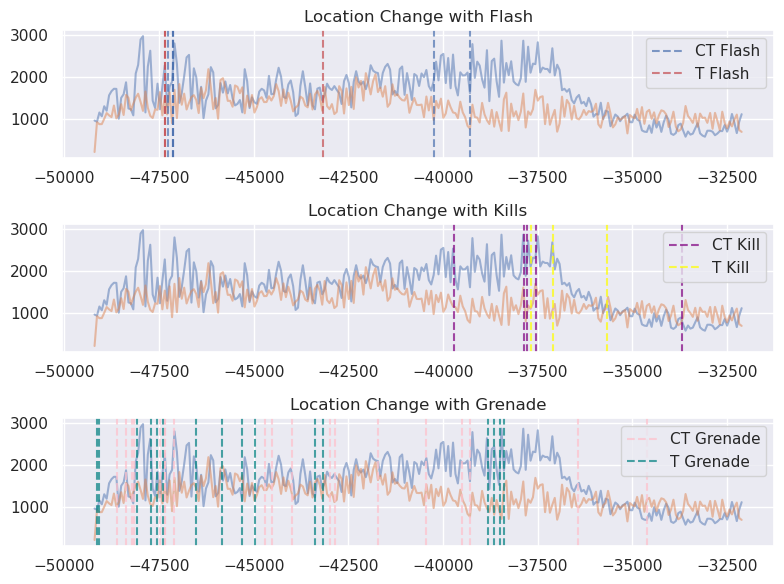

In [43]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots vertically
fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # 3 rows, 1 column, adjust figsize as needed

# Location Change Data (Calculate only once)
sel_loc = idx_pf_df.loc[sel_idx][["tick", "side", "x", "y"]]
first_tick = idx_r_df.loc[sel_idx]["start_tick"]
sel_loc["tick"] = sel_loc["tick"] - first_tick
curr_x = sel_loc.iloc[1:]["x"]
prev_x = sel_loc.iloc[:-1]["x"]
curr_y = sel_loc.iloc[1:]["y"]
prev_y = sel_loc.iloc[:-1]["y"]
loc_change = [0] + list(np.sqrt((curr_x - prev_x) ** 2 + (curr_y - prev_y) ** 2))
sel_loc["loc_change"] = loc_change
sel_team_loc = sel_loc.groupby(["side", "tick"]).agg(avg_loc_change=("loc_change", "mean"))

ct_loc_df = sel_team_loc.loc["CT"].reset_index()
t_loc_df = sel_team_loc.loc["T"].reset_index()

# 1st Subplot: Location Change with Flash
axes[0].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)
axes[0].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)

sel_f = idx_f_df.loc[sel_idx].reset_index()
sel_f["tick"] = sel_f["tick"] - first_tick
for attacker_side in ["CT", "T"]:
    flash_ticks = sel_f[sel_f.attacker_side == attacker_side]["tick"]
    for tick_value in flash_ticks:
        if attacker_side == "CT":
            ct_f = axes[0].axvline(x=tick_value, color='b', linestyle='--', alpha=0.7, label="CT Flash")
        else:
            t_f = axes[0].axvline(x=tick_value, color='r', linestyle='--', alpha=0.7, label="T Flash")
axes[0].set_title("Location Change with Flash")
axes[0].legend(handles = [ct_f,t_f])

# 2nd Subplot: Location Change with Kills
axes[1].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change
axes[1].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change

sel_k = idx_k_df.loc[sel_idx].reset_index()
sel_k["tick"] = sel_k["tick"] - first_tick
for attacker_side in ["CT", "T"]:
    kill_ticks = sel_k[sel_k.attacker_side == attacker_side]["tick"]
    for tick_value in kill_ticks:
        if attacker_side == "CT":
            ct_k = axes[1].axvline(x=tick_value, color="purple", linestyle='--', alpha=0.7, label="CT Kill")
        else:
            t_k = axes[1].axvline(x=tick_value, color='yellow', linestyle='--', alpha=0.7, label="T Kill")
axes[1].set_title("Location Change with Kills")
axes[1].legend(handles=[ct_k,t_k])

# 3rd Subplot: Location Change with Grenade
axes[2].plot(ct_loc_df["tick"], ct_loc_df["avg_loc_change"], label="CT Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change
axes[2].plot(t_loc_df["tick"], t_loc_df["avg_loc_change"], label="T Avg. Loc. Change", alpha=0.5)  # Use pre-calculated location change

sel_g = idx_g_df.loc[sel_idx].reset_index()
sel_g["throw_tick"] = sel_g["throw_tick"] - first_tick
for thrower_side in ["CT", "T"]:
    grenade_ticks = sel_g[sel_g.thrower_side == thrower_side]["throw_tick"]
    for tick_value in grenade_ticks:
        if thrower_side == "CT":
            ct_g = axes[2].axvline(x=tick_value, color="pink", linestyle='--', alpha=0.7, label="CT Grenade")
        else:
            t_g = axes[2].axvline(x=tick_value, color='teal', linestyle='--', alpha=0.7, label="T Grenade")
axes[2].set_title("Location Change with Grenade")
axes[2].legend(handles=[ct_g,t_g])

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()


# eda with money related columns

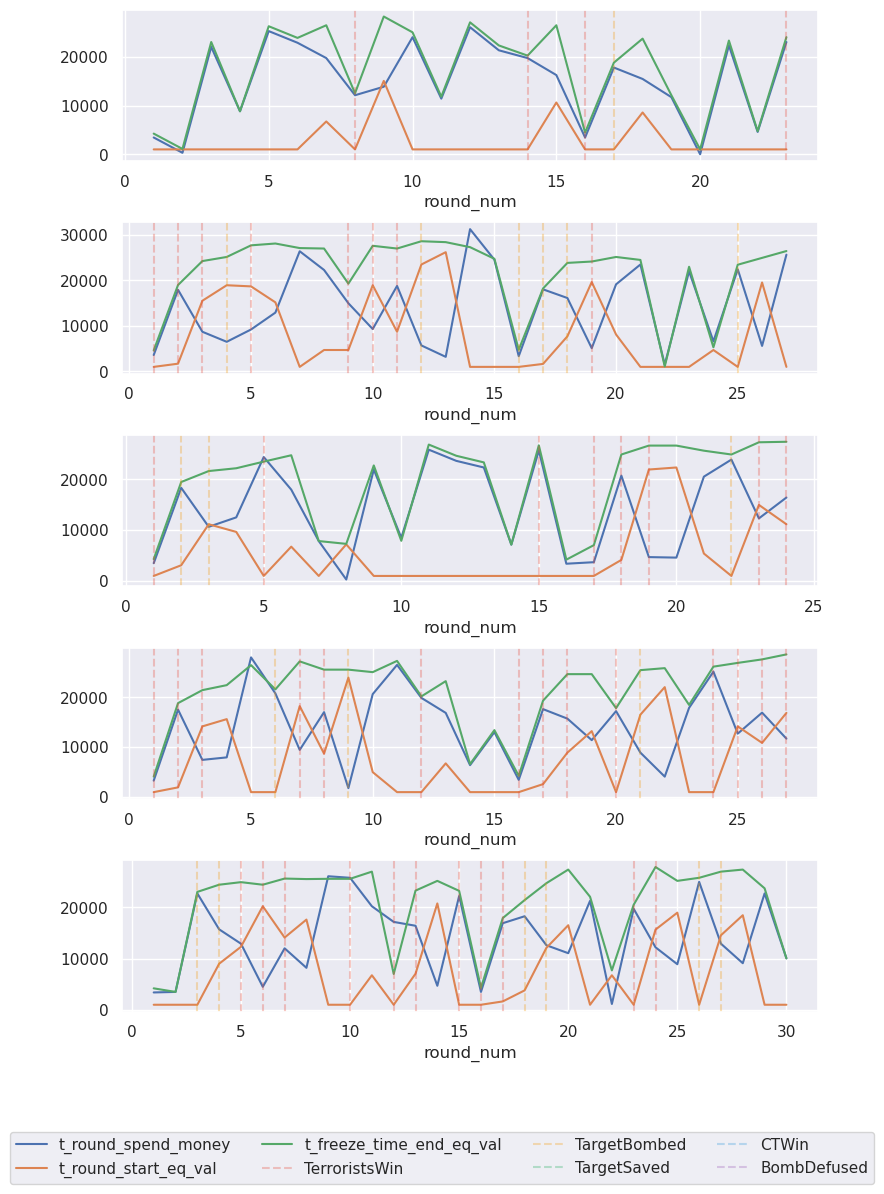

In [71]:
money_cols = ["ct_round_spend_money","ct_round_start_eq_val","ct_freeze_time_end_eq_val","t_round_spend_money","t_round_start_eq_val","t_freeze_time_end_eq_val"]
win_reason_colors = {
    'TerroristsWin': '#e74c3c',    # Bright red
    'TargetBombed': '#f39c12',     # Golden yellow
    'TargetSaved': '#27ae60',      # Emerald green
    'CTWin': '#3498db',            # Bright blue
    'BombDefused': '#9b59b6'       # Purple
}
winning_side = "t"
side_money_cols = [col for col in money_cols if col.startswith(f"{winning_side}_")]
fig,axes = plt.subplots(5,1,figsize=(8,12))
for i in range(5):
    m_r_df = sel_r_df.loc[selected_matches.iloc[i].match_id]
    side_money_df = m_r_df[side_money_cols+["winning_side","round_end_reason"]]
    side_money_df[side_money_cols].plot.line(ax=axes[i], legend=False)  # Don't show legend on each subplot
    
    for idx,row in side_money_df.iterrows():
        if row["winning_side"].lower()==winning_side:
            axes[i].axvline(x=idx,linestyle="--",alpha=0.3,color=win_reason_colors[row["round_end_reason"]])

# Add money lines to legend
handles, labels = axes[0].get_legend_handles_labels()

# Add win reasons to legend with simple lines
for reason, color in win_reason_colors.items():
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--', alpha=0.3))
    labels.append(reason)

# Add a single legend at the bottom of the figure with all elements
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust this value as needed

In [46]:
sel_r_df.round_end_reason.unique()

['TerroristsWin', 'TargetBombed', 'TargetSaved', 'CTWin', 'BombDefused']
Categories (5, object): ['BombDefused', 'CTWin', 'TargetBombed', 'TargetSaved', 'TerroristsWin']

In [47]:
e_d_r_df = sel_r_df[["round_end_reason","winning_side","ct_kills","t_kills","ct_deaths","t_deaths"]]
e_d_r_df

round_end_reason winning_side  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1            TerroristsWin            T   
                                     2             TargetBombed            T   
                                     3             TargetBombed            T   
                                     4              TargetSaved           CT   
                                     5                    CTWin           CT   
...                                                         ...          ...   
816e1612-9d2e-4893-af23-bda90c479598 13                   CTWin           CT   
                                     14                   CTWin           CT   
                                     15                   CTWin           CT   
                                     16             BombDefused           CT   
                                     17           TerroristsWin            T   

                                                ct_kills  t_kills  ct_deaths  \
match_id                             round_num                                 
bfa9bbbe-bd16-4713-bd99-745378db05cb 1               3.0      5.0        5.0   
                                     2               1.0      3.0        3.0   
                                     3               1.0      3.0        4.0   
                                     4               3.0      5.0        5.0   
                                     5               5.0      1.0        1.0   
...                                                  ...      ...        ...   
816e1612-9d2e-4893-af23-bda90c479598 13              5.0      1.0        1.0   
                                     14              5.0      1.0        1.0   
                                     15              5.0      1.0        1.0   
                                     16              5.0      4.0        4.0   
                                     17              4.0      5.0        5.0   

                                                t_deaths  
match_id                             round_num            
bfa9bbbe-bd16-4713-bd99-745378db05cb 1               3.0  
                                     2               1.0  
                                     3               1.0  
                                     4               3.0  
                                     5               5.0  
...                                                  ...  
816e1612-9d2e-4893-af23-bda90c479598 13              5.0  
                                     14              5.0  
                                     15              5.0  
                                     16              5.0  
                                     17              4.0  

[1312 rows x 6 columns]

In [53]:
e_d_r_df[(e_d_r_df.round_end_reason=="CTWin") & (e_d_r_df.t_deaths != 5)]

,,round_end_reason,winning_side,ct_kills,t_kills,ct_deaths,t_deaths
match_id,round_num,,,,,,
d2dff070-d216-4b59-9edd-1e20e9518a8a,8,CTWin,CT,4.0,2.0,2.0,4.0
b9e6964c-9dc2-4d86-9a6b-be7cff8a039a,6,CTWin,CT,4.0,1.0,1.0,4.0
e2f49be0-bb4f-4968-b96b-a608a18bb7ba,9,CTWin,CT,4.0,1.0,1.0,4.0


In [60]:
matches = e_d_r_df[(e_d_r_df.round_end_reason=="CTWin") & (e_d_r_df.t_deaths != 5)].index.to_list()
print(matches)
matches = [p[0] for p in matches]
matches

[('d2dff070-d216-4b59-9edd-1e20e9518a8a', 8), ('b9e6964c-9dc2-4d86-9a6b-be7cff8a039a', 6), ('e2f49be0-bb4f-4968-b96b-a608a18bb7ba', 9)]


['d2dff070-d216-4b59-9edd-1e20e9518a8a',
 'b9e6964c-9dc2-4d86-9a6b-be7cff8a039a',
 'e2f49be0-bb4f-4968-b96b-a608a18bb7ba']

In [59]:
for _,match in matches_df.iterrows():
    for tm in matches:
        if match["match_id"] == tm:
            display(match)

client_name                                                      GOTV Demo
map_name                                                       de_overpass
tick_rate                                                              128
playback_ticks                                                      533569
playback_frames_count                                               532259
parsed_to_frame_idx                                                 532274
match_id                              d2dff070-d216-4b59-9edd-1e20e9518a8a
demo_id                               01be4691-e8c9-4c2a-a158-13e74e773e22
competition_name                            BLAST Premier Fall Groups 2021
hltv_url                 https://www.hltv.org/matches/2350998/astralis-...
match_date                                                   1631889000000
match_name               astralis-vs-vitality-blast-premier-fall-groups...
Name: 0, dtype: object

client_name                                                      GOTV Demo
map_name                                                        de_inferno
tick_rate                                                              128
playback_ticks                                                      494095
playback_frames_count                                               493292
parsed_to_frame_idx                                                 493312
match_id                              b9e6964c-9dc2-4d86-9a6b-be7cff8a039a
demo_id                               065d1b20-430b-41cf-9ad3-a4ccabf09d28
competition_name                            BLAST Premier World Final 2021
hltv_url                 https://www.hltv.org/matches/2353593/gambit-vs...
match_date                                                   1639510800000
match_name                 gambit-vs-heroic-blast-premier-world-final-2021
Name: 0, dtype: object

client_name                                                      GOTV Demo
map_name                                                        de_vertigo
tick_rate                                                              128
playback_ticks                                                      461326
playback_frames_count                                               459833
parsed_to_frame_idx                                                 459848
match_id                              e2f49be0-bb4f-4968-b96b-a608a18bb7ba
demo_id                               0479641c-b9fd-4dd9-9575-0d7c64700eff
competition_name                          BLAST Premier Spring Groups 2021
hltv_url                 https://www.hltv.org/matches/2346331/evil-geni...
match_date                                                   1612809000000
match_name               evil-geniuses-vs-g2-blast-premier-spring-group...
Name: 0, dtype: object

In [50]:
e_d_r_df[(e_d_r_df.round_end_reason=="TerroriWin") & (e_d_r_df.ct_deaths != 5)]

,,round_end_reason,winning_side,ct_kills,t_kills,ct_deaths,t_deaths
match_id,round_num,,,,,,


In [52]:
e_d_r_df[(e_d_r_df.round_end_reason=="BombDefused") & (e_d_r_df.winning_side != "CT")]

,,round_end_reason,winning_side,ct_kills,t_kills,ct_deaths,t_deaths
match_id,round_num,,,,,,


In [61]:
idx_k_df.loc[('d2dff070-d216-4b59-9edd-1e20e9518a8a', 8)]

tick    seconds clock_time  \
match_id                             round_num                               
d2dff070-d216-4b59-9edd-1e20e9518a8a 8          5959  26.554688      01:29   
                                     8          5995  26.835938      01:29   
                                     8          6150  28.046875      01:27   
                                     8          6689  32.257812      01:23   
                                     8          6768  32.875000      01:23   
                                     8          7094  35.421875      01:20   

                                                attacker_steam_id  \
match_id                             round_num                      
d2dff070-d216-4b59-9edd-1e20e9518a8a 8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   
                                     8               7.656120e+16   

                                               attacker_name attacker_team  \
match_id                             round_num                               
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                 Xyp9x      Astralis   
                                     8              misutaaa  TeamVitality   
                                     8               Bubzkji      Astralis   
                                     8                Magisk      Astralis   
                                     8                Magisk      Astralis   
                                     8                 shox   TeamVitality   

                                               attacker_side   attacker_x  \
match_id                             round_num                              
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                    CT  -483.284790   
                                     8                     T  -558.151367   
                                     8                    CT  -664.733337   
                                     8                    CT  -654.614685   
                                     8                    CT  -655.277039   
                                     8                     T -1017.250732   

                                                attacker_y  attacker_z  ...  \
match_id                             round_num                          ...   
d2dff070-d216-4b59-9edd-1e20e9518a8a 8         -139.707809    5.379532  ...   
                                     8         -454.440430    7.832283  ...   
                                     8          252.836273   23.889938  ...   
                                     8          298.158112   25.474077  ...   
                                     8          298.153137   25.459402  ...   
                                     8         -626.854126   96.031250  ...   

                                                player_traded_team  \
match_id                             round_num                       
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                         NaN   
                                     8                TeamVitality   
                                     8                    Astralis   
                                     8                         NaN   
                                     8                         NaN   
                                     8                         NaN   

                                                player_traded_steam_id  \
match_id                             round_num                           
d2dff070-d216-4b59-9edd-1e20e9518a8a 8                             NaN   
                                     8                    7.656120e+16   
                                     8                    7.656120e+16   
                                     8                          

<Axes: xlabel='round_end_reason'>

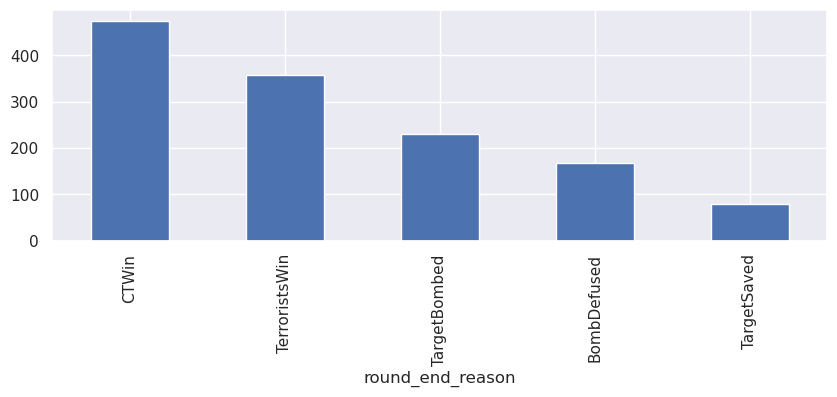

In [65]:
idx_r_df.value_counts("round_end_reason").plot.bar()